In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import scipy.io as sio
from keras.layers import Conv1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks  import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, auc
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks  import EarlyStopping
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
#dataPath = '../data/butter_feature_tensor_with_labels.mat'
#dataPath = '../data/csp_features_full_with_full_labels.csv'
dataPath = '../data/csp_feat_matrix_full_with_full_labels_3.mat'
savePath = '../Results/CSP_3/'

experiment = 'HALA_csp_1d_input_Full'

filename = savePath+'CNN_1D_results_'+experiment+'.mat'
plot_title = 'HA vs LA Classification for CSP Features - Full'

nb_filters = [16, 32, 32, 64, 128]
kernel_size = 3
pool_size = 2
stride_size = 2
padding = 'same'
weight_decay = 0.000001
dense_layer_neuron_num = 128
epochs = 30
momentum =0.8

matContent = sio.loadmat(dataPath)
features = matContent['full_feat']
labels = np.squeeze(matContent['full_hala_labels'])
labels[labels < 0] = 0
#labels[labels == 6] = 0
#labels = labels.astype(int)

#df = pd.read_csv(dataPath, header = None)
#features = df.iloc[1:,:-2].to_numpy()
#labels = df.iloc[1:,-1].to_numpy() # last but one column for PD vs NC

#dict_hvlv = {1:0, 2:1, 3:0, 4:0, 5:1, 6:0} #HVLV labels mapping dictionary
#labels = labels.map(dict_hvlv).to_numpy()
#labels[labels == 1] = 0
#labels[labels == 2] = 1
#labels[labels == 3] = 1
#labels[labels == 4] = 1
#labels[labels == 5] = 1
#labels[labels == 6] = 1
#labels[labels < 0]=0
#labels[labels == 6]=0

# randomise the sample sequence
rand_order = np.arange(features.shape[0])
np.random.shuffle(rand_order)
features = features[rand_order,]
labels = np.squeeze(labels[rand_order,])
class_num = np.size(np.unique(labels))
labels_categorical = np_utils.to_categorical(labels, class_num)
del matContent

In [3]:
labels_categorical

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [4]:
class_num

2

In [5]:
features.shape

(14633, 6)

In [6]:
np.unique(labels)

array([0, 1], dtype=uint8)

In [7]:
def create_model(init_mode, activation, dropout_rate, optimizer, learn_rate):
#def create_model(activation):
  model = Sequential()
  model.add(Conv1D(filters=nb_filters[0], kernel_size=kernel_size, padding=padding,
                   activation=activation, input_shape=(X.shape[1], X.shape[2]), trainable=True))
  model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv1D(filters=nb_filters[1], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv1D(filters=nb_filters[2], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  #model.add(Conv1D(filters=nb_filters[3], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  #model.add(Conv1D(filters=nb_filters[4], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  model.add(Flatten())
  model.add(BatchNormalization(epsilon=0.001))
  model.add(Dense(dense_layer_neuron_num, kernel_initializer=init_mode, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(class_num))
  model.add(Activation('softmax'))
  #model.summary()
  #model.load_weights('Gender_notClean_HIweights.hdf5')
  #earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
  if optimizer == 'SGD':
    opt = SGD(learning_rate=learn_rate / 10 ** epochs, momentum = momentum, decay = weight_decay, nesterov = True)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'Adam':
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'RMSprop':
    opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


In [8]:
cnn_model = KerasClassifier(build_fn=create_model, verbose=0)

#batch_size = [16,32]
#epochs = [5,10,15]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'he_normal', 'he_uniform']
#activation = ['softmax', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#neurons = [1, 5, 10, 15, 20, 25, 30]

learn_rate = [0.001, 0.01, 0.1]
optimizer = ['SGD', 'Adam','RMSprop']
#momentum = [0.8,0.9]
init_mode = ['he_normal','he_uniform']
activation = ['relu','tanh']
dropout_rate = [0.3,0.4,0.5]
foldNum = 10

p_grid = dict(init_mode=init_mode, dropout_rate=dropout_rate, activation=activation,
              optimizer=optimizer, learn_rate=learn_rate)
              #, momentum=momentum)
grid = GridSearchCV(estimator=cnn_model, param_grid=p_grid,
                    cv=foldNum, verbose=0)
# Standerdize
feat_shape = features.shape
#features = np.reshape(features, (feat_shape[0], feat_shape[1]*feat_shape[2]))
scaler = StandardScaler()
scaler.fit(features)
scaleFeatures = scaler.transform(features)
scaleFeatures = np.reshape(scaleFeatures, (features.shape[0], 6, -1))

print('Performing Gridsearch')
X = scaleFeatures
Y = labels_categorical
grid_result = grid.fit(X,Y)
best_params = grid_result.best_params_
print('Best parameters:', best_params)
estimator = create_model(init_mode=best_params.get('init_mode'), 
                         learn_rate=best_params.get('learn_rate'), 
                         optimizer=best_params.get('optimizer'), 
                         #momentum=best_params.get('momentum'), 
                         activation=best_params.get('activation'), 
                         dropout_rate=best_params.get('dropout_rate'))

Performing Gridsearch
Best parameters: {'activation': 'relu', 'dropout_rate': 0.3, 'init_mode': 'he_uniform', 'learn_rate': 0.01, 'optimizer': 'RMSprop'}


Model: "sequential_1081"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3243 (Conv1D)         (None, 6, 16)             64        
_________________________________________________________________
average_pooling1d_3243 (Aver (None, 3, 16)             0         
_________________________________________________________________
conv1d_3244 (Conv1D)         (None, 3, 32)             1568      
_________________________________________________________________
average_pooling1d_3244 (Aver (None, 2, 32)             0         
_________________________________________________________________
conv1d_3245 (Conv1D)         (None, 2, 32)             3104      
_________________________________________________________________
average_pooling1d_3245 (Aver (None, 1, 32)             0         
_________________________________________________________________
flatten_1081 (Flatten)       (None, 32)            

Epoch 5/30
371/371 - 1s - loss: 0.2515 - accuracy: 0.9017 - val_loss: 0.2520 - val_accuracy: 0.9127
Epoch 6/30
371/371 - 2s - loss: 0.2595 - accuracy: 0.9017 - val_loss: 0.2922 - val_accuracy: 0.8990
Epoch 7/30
371/371 - 2s - loss: 0.2493 - accuracy: 0.9077 - val_loss: 0.3641 - val_accuracy: 0.8656
Epoch 8/30
371/371 - 1s - loss: 0.2542 - accuracy: 0.9044 - val_loss: 0.8565 - val_accuracy: 0.8474
Epoch 9/30
371/371 - 1s - loss: 0.2548 - accuracy: 0.9077 - val_loss: 0.2563 - val_accuracy: 0.9127
Epoch 10/30
371/371 - 1s - loss: 0.2584 - accuracy: 0.9019 - val_loss: 0.3392 - val_accuracy: 0.8550
Epoch 11/30
371/371 - 2s - loss: 0.2625 - accuracy: 0.9035 - val_loss: 0.3222 - val_accuracy: 0.8709
Epoch 12/30
371/371 - 2s - loss: 0.2566 - accuracy: 0.9018 - val_loss: 0.2638 - val_accuracy: 0.9165
Epoch 13/30
371/371 - 1s - loss: 0.2593 - accuracy: 0.8998 - val_loss: 0.3026 - val_accuracy: 0.8603
Epoch 14/30
371/371 - 1s - loss: 0.2549 - accuracy: 0.9025 - val_loss: 0.3840 - val_accuracy: 0.

371/371 - 13s - loss: 0.2510 - accuracy: 0.9117 - val_loss: 0.3384 - val_accuracy: 0.9119
Epoch 2/30
371/371 - 1s - loss: 0.2443 - accuracy: 0.9153 - val_loss: 0.3319 - val_accuracy: 0.9134
Epoch 3/30
371/371 - 1s - loss: 0.2449 - accuracy: 0.9132 - val_loss: 0.3193 - val_accuracy: 0.9089
Epoch 4/30
371/371 - 1s - loss: 0.2449 - accuracy: 0.9126 - val_loss: 0.3095 - val_accuracy: 0.9051
Epoch 5/30
371/371 - 1s - loss: 0.2502 - accuracy: 0.9142 - val_loss: 0.2922 - val_accuracy: 0.9112
Epoch 6/30
371/371 - 1s - loss: 0.2527 - accuracy: 0.9131 - val_loss: 0.3390 - val_accuracy: 0.9089
Epoch 7/30
371/371 - 1s - loss: 0.2665 - accuracy: 0.9098 - val_loss: 0.4328 - val_accuracy: 0.8952
Epoch 8/30
371/371 - 1s - loss: 0.2479 - accuracy: 0.9141 - val_loss: 0.5370 - val_accuracy: 0.8671
Epoch 9/30
371/371 - 1s - loss: 0.2574 - accuracy: 0.9131 - val_loss: 0.3457 - val_accuracy: 0.9112
Epoch 10/30
371/371 - 1s - loss: 0.2512 - accuracy: 0.9145 - val_loss: 0.3413 - val_accuracy: 0.9119
Epoch 11/

371/371 - 1s - loss: 0.2343 - accuracy: 0.9122 - val_loss: 0.3590 - val_accuracy: 0.8975
Epoch 2/30
371/371 - 1s - loss: 0.2357 - accuracy: 0.9168 - val_loss: 0.5383 - val_accuracy: 0.8208
Epoch 3/30
371/371 - 1s - loss: 0.2203 - accuracy: 0.9183 - val_loss: 0.3141 - val_accuracy: 0.8853
Epoch 4/30
371/371 - 1s - loss: 0.2276 - accuracy: 0.9183 - val_loss: 0.3608 - val_accuracy: 0.9172
Epoch 5/30
371/371 - 1s - loss: 0.2290 - accuracy: 0.9160 - val_loss: 0.3289 - val_accuracy: 0.9157
Epoch 6/30
371/371 - 1s - loss: 0.2247 - accuracy: 0.9162 - val_loss: 0.3266 - val_accuracy: 0.8960
Epoch 7/30
371/371 - 1s - loss: 0.2228 - accuracy: 0.9177 - val_loss: 0.3652 - val_accuracy: 0.9081
Epoch 8/30
371/371 - 1s - loss: 0.2193 - accuracy: 0.9198 - val_loss: 0.3894 - val_accuracy: 0.9134
Epoch 9/30
371/371 - 1s - loss: 0.2249 - accuracy: 0.9162 - val_loss: 0.4925 - val_accuracy: 0.8770
Epoch 10/30
371/371 - 1s - loss: 0.2237 - accuracy: 0.9204 - val_loss: 0.2653 - val_accuracy: 0.9074
Epoch 11/3

371/371 - 1s - loss: 0.2088 - accuracy: 0.9226 - val_loss: 0.4007 - val_accuracy: 0.9180
Epoch 2/30
371/371 - 1s - loss: 0.2009 - accuracy: 0.9248 - val_loss: 0.2871 - val_accuracy: 0.9271
Epoch 3/30
371/371 - 1s - loss: 0.2094 - accuracy: 0.9242 - val_loss: 0.2871 - val_accuracy: 0.9203
Epoch 4/30
371/371 - 1s - loss: 0.2041 - accuracy: 0.9266 - val_loss: 0.5409 - val_accuracy: 0.8907
Epoch 5/30
371/371 - 1s - loss: 0.1982 - accuracy: 0.9272 - val_loss: 0.3293 - val_accuracy: 0.9180
Epoch 6/30
371/371 - 1s - loss: 0.1989 - accuracy: 0.9257 - val_loss: 0.2924 - val_accuracy: 0.9226
Epoch 7/30
371/371 - 1s - loss: 0.1982 - accuracy: 0.9242 - val_loss: 0.2583 - val_accuracy: 0.9233
Epoch 8/30
371/371 - 1s - loss: 0.2131 - accuracy: 0.9231 - val_loss: 0.3113 - val_accuracy: 0.9096
Epoch 9/30
371/371 - 1s - loss: 0.2056 - accuracy: 0.9263 - val_loss: 0.3071 - val_accuracy: 0.9157
Epoch 10/30
371/371 - 1s - loss: 0.2077 - accuracy: 0.9260 - val_loss: 0.2951 - val_accuracy: 0.9188
Epoch 11/3

371/371 - 1s - loss: 0.2042 - accuracy: 0.9240 - val_loss: 0.2394 - val_accuracy: 0.9271
Epoch 2/30
371/371 - 1s - loss: 0.1957 - accuracy: 0.9274 - val_loss: 0.2899 - val_accuracy: 0.9210
Epoch 3/30
371/371 - 1s - loss: 0.1969 - accuracy: 0.9269 - val_loss: 0.2895 - val_accuracy: 0.9112
Epoch 4/30
371/371 - 1s - loss: 0.2080 - accuracy: 0.9249 - val_loss: 0.2848 - val_accuracy: 0.9218
Epoch 5/30
371/371 - 1s - loss: 0.2003 - accuracy: 0.9264 - val_loss: 0.3277 - val_accuracy: 0.9021
Epoch 6/30
371/371 - 1s - loss: 0.1988 - accuracy: 0.9233 - val_loss: 0.3475 - val_accuracy: 0.8724
Epoch 7/30
371/371 - 1s - loss: 0.2013 - accuracy: 0.9237 - val_loss: 0.2808 - val_accuracy: 0.9180
Epoch 8/30
371/371 - 1s - loss: 0.1974 - accuracy: 0.9254 - val_loss: 0.3039 - val_accuracy: 0.9248
Epoch 9/30
371/371 - 1s - loss: 0.2065 - accuracy: 0.9256 - val_loss: 0.2476 - val_accuracy: 0.9165
Epoch 10/30
371/371 - 1s - loss: 0.2031 - accuracy: 0.9284 - val_loss: 0.2341 - val_accuracy: 0.9150
Epoch 11/3

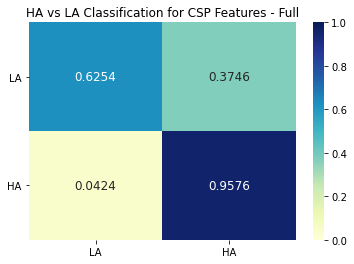

Mean and std of F1 MACRO is 0.7978 +- 0.0798
Mean and std of F1 WEIGHTED is 0.8956 +- 0.0317
Mean and std of accuracy is 0.9033 +- 0.0193


In [9]:
conf_mat = np.zeros((2,2))
f = 0
f1_MacroNet = np.zeros([foldNum,]) 
f1_weightedNet = np.zeros([foldNum,])
precisionNet = np.zeros([foldNum,])
recallNet = np.zeros([foldNum,])
accNet = np.zeros([foldNum,])

#channels = features.shape[2] # number of channels 14
kfold = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)

features = np.reshape(features, (features.shape[0],6,-1)) #reshaped to (None, 3, 14) for spectral

for train, test in kfold.split(features, labels):
  trainingFeatures = features[train,:,:]
  testFeatures = features[test,:,:]
  train_shape = trainingFeatures.shape
  test_shape = testFeatures.shape
  
  # Standerdize 
  scaler = StandardScaler()
  trainingFeatures = np.reshape(trainingFeatures, [train_shape[0], train_shape[1]*train_shape[2]])
  testFeatures = np.reshape(testFeatures, [test_shape[0], test_shape[1]*test_shape[2]])
  scaler.fit(trainingFeatures)
  trainingFeatures = scaler.transform(trainingFeatures)
  trainingFeatures = np.reshape(trainingFeatures, [train_shape[0],train_shape[1],train_shape[2]])
  testFeatures = scaler.transform(testFeatures)
  testFeatures = np.reshape(testFeatures,[test_shape[0], test_shape[1], test_shape[2]])
  estimator.summary()
  estimator.fit(trainingFeatures, labels_categorical[train,:], batch_size=32, 
                epochs=epochs, verbose=2, validation_split=0.1)

  predicted_labelsNet = estimator.predict_classes(testFeatures, verbose=0)
  predicted_probsNet = estimator.predict_proba(testFeatures,batch_size=1,verbose=0)
  cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[0,1])
  conf_mat = conf_mat+cm

  precisionNet[f] = precision_score(labels[test,], predicted_labelsNet, average='macro')
  recallNet[f] = recall_score(labels[test,], predicted_labelsNet, average='macro')
  f1_MacroNet[f] = f1_score(labels[test,], predicted_labelsNet, average='macro')
  f1_weightedNet[f] = f1_score(labels[test,], predicted_labelsNet, average='weighted')
  accNet[f] = accuracy_score(labels[test,], predicted_labelsNet)
  print(experiment + '_CNN: Fold %d : f1_macroscore: %.4f' % (f + 1, f1_MacroNet[f]))
  print(experiment + '_CNN: Fold %d : f1_weightedscore: %.4f' % (f + 1, f1_weightedNet[f]))
  print(experiment + '_CNN: Fold %d : acc: %.4f' % (f + 1, accNet[f]))
  f += 1

conf_mat /= conf_mat.sum(axis=1, keepdims = True)
ax = sns.heatmap(conf_mat, cmap='YlGnBu', annot = True, fmt='.4f', vmin=0, vmax=1, annot_kws = {'fontsize':12})
#ax.set_yticklabels(['NC', 'PD'], rotation = 0) # for CSP and IIR
#ax.set_yticklabels(['PD', 'NC'], rotation = 0) # for spectral
ax.set_yticklabels(['LA', 'HA'], rotation = 0)
#ax.set_yticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
#ax.set_xticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
ax.set_xticklabels(['LA', 'HA'], rotation = 0)
#ax.set_xticklabels(['NC', 'PD'], rotation = 0) # for CSP and IIR
#ax.set_xticklabels(['PD', 'NC'], rotation = 0) # for spectral

ax.set_title(plot_title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

print('Mean and std of F1 MACRO is %.4f +- %.4f' % (np.mean(f1_MacroNet), np.std(f1_MacroNet)))
print('Mean and std of F1 WEIGHTED is %.4f +- %.4f' % (np.mean(f1_weightedNet), np.std(f1_weightedNet)))
print('Mean and std of accuracy is %.4f +- %.4f' % (np.mean(accNet), np.std(accNet)))

# Save results
sio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,
                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat,
                      'best_params':best_params, 'experiment':experiment,'nb_filters':nb_filters,
                       'kernel_size':kernel_size, 'pool_size':pool_size, 'stride_size':stride_size,'padding':padding,
                       'weight_decay':weight_decay, 'dense_layer_neuron_num':dense_layer_neuron_num,'epochs':epochs})